_Version log: Branch of V19. Trying out a new way of boundry checking and randomising the samples_

_Update: I resurrected V24 in order to make a nice graph demonstrating wide detectors._

In [115]:
import sys, warnings
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
from sklearn.exceptions import ConvergenceWarning
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft as spfft
from scipy.constants import c as C
from tqdm import tqdm
import CS_functions as cs
warnings.filterwarnings("ignore", category= ConvergenceWarning)
plt.rcParams.update({'font.size':24, 'xtick.minor.visible': True, 'ytick.minor.visible': False,
                     'xtick.direction': 'in', 'ytick.direction': 'in', "xtick.top": True, "ytick.right": True,
                     'lines.linewidth': 2.4, 'lines.markersize': 10.0, 'lines.markeredgewidth': 2.4})
np.set_printoptions(threshold=sys.maxsize)

In [167]:
file_name = "1dmockanderrors17"
file_type = ".csv"
pixel_pitch = 0.5 # in mm
theta = 200 # in arcmins
total_points = 16
central_freq = 0.9e12 # in Hz
FWHM_freq = 0.9e12 # in Hz
read_noise = 0.0

target = cs.generate_interferogram(total_points, pixel_pitch *1e-3, central_freq, FWHM_freq, theta /60, read_noise_sigma= read_noise)
displacement = np.arange((1-total_points)//2, (1+total_points)//2, dtype= float)
displacement *= pixel_pitch
displacement = np.fft.fftshift(displacement)

target_smooth = cs.generate_interferogram(total_points*100, pixel_pitch *1e-4, central_freq, FWHM_freq, theta /60, read_noise_sigma= read_noise)
displacement_smooth = np.arange((1-total_points*100)//2, (1+total_points*100)//2, dtype= float)
displacement_smooth *= pixel_pitch * 1e-1
displacement_smooth = np.fft.fftshift(displacement_smooth)

[-2.77258872 -1.14257318 -0.22345954 -0.0152478  -0.51793797 -1.73153003
 -3.656024   -6.29141987 -9.63771763]
[-2.77258872e+00 -2.57759658e+00 -2.38971346e+00 -2.20893936e+00
 -2.03527428e+00 -1.86871821e+00 -1.70927117e+00 -1.55693314e+00
 -1.41170414e+00 -1.27358415e+00 -1.14257318e+00 -1.01867123e+00
 -9.01878301e-01 -7.92194390e-01 -6.89619498e-01 -5.94153624e-01
 -5.05796770e-01 -4.24548934e-01 -3.50410118e-01 -2.83380320e-01
 -2.23459542e-01 -1.70647783e-01 -1.24945042e-01 -8.63513210e-02
 -5.48666187e-02 -3.04909354e-02 -1.32242711e-02 -3.06662579e-03
 -1.79995193e-05 -4.07839226e-03 -1.52478040e-02 -3.35262348e-02
 -5.89136846e-02 -9.14101534e-02 -1.31015641e-01 -1.77730148e-01
 -2.31553674e-01 -2.92486219e-01 -3.60527783e-01 -4.35678365e-01
 -5.17937967e-01 -6.07306588e-01 -7.03784228e-01 -8.07370887e-01
 -9.18066565e-01 -1.03587126e+00 -1.16078498e+00 -1.29280771e+00
 -1.43193947e+00 -1.57818024e+00 -1.73153003e+00 -1.89198884e+00
 -2.05955667e+00 -2.23423352e+00 -2.41601939

In [ ]:
IRF_FWHM = 1.34 # in mm
sinc_half = 0.603354564401614 # result taken from wolfram alpha. true for sinc(x) = sin(pi*x)/(pi*x) which is the definition used by numpy.
base = IRF_FWHM/sinc_half

IRF = 2*np.pi/base * np.sinc(displacement *2*sinc_half/IRF_FWHM) # rescale by new FWHM such that the fourier transform peaks at 1
IRF_FFT = np.fft.rfft(IRF, norm= "forward")
IRF_spec = np.abs(IRF_FFT)
IRF_smooth = 2*np.pi/base * np.sinc(displacement_smooth *2*sinc_half/IRF_FWHM)
IRF_smooth_FFT = np.fft.rfft(IRF_smooth, norm= "backward") # HOW DO I NORMALISE THIS LIKE A CONTINUOUS FOURIER TRANSFORM???? /(displacement_smooth.max() - displacement_smooth.min())
IRF_smooth_spec = np.abs(IRF_smooth_FFT)

target_FFT = np.fft.rfft(target, norm= "forward")
target_spec = np.abs(target_FFT)
target_smooth_FFT = np.fft.rfft(target_smooth, norm= "forward")
target_smooth_spec = np.abs(target_smooth_FFT)

convol_FFT = target_FFT *IRF_FFT
convol_spec = np.abs(convol_FFT)
convol = np.fft.irfft(convol_FFT, norm= "forward")
convol_smooth_FFT = target_smooth_FFT *IRF_smooth_FFT
convol_smooth_spec = np.abs(convol_smooth_FFT)

wavenum = np.fft.rfftfreq(len(target), pixel_pitch) # in mm^-1
freqs = wavenum*10**3 * C / (2*np.sin(np.deg2rad(theta/60))) # in Hz
freqs *= 1e-12 # in THz
wavenum_smooth = np.fft.rfftfreq(len(target_smooth), pixel_pitch*1e-2) # in mm^-1
freqs_smooth = wavenum_smooth*10**3 * C / (2*np.sin(np.deg2rad(theta/60))) # in Hz
freqs_smooth *= 1e-12 # in THz

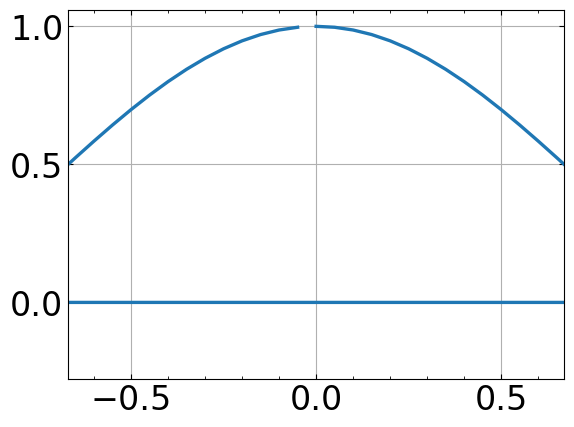

In [218]:
plt.plot(displacement_smooth, IRF_smooth / IRF_smooth.max())
plt.xlim(-IRF_FWHM/2, IRF_FWHM/2)
plt.grid()
plt.show()

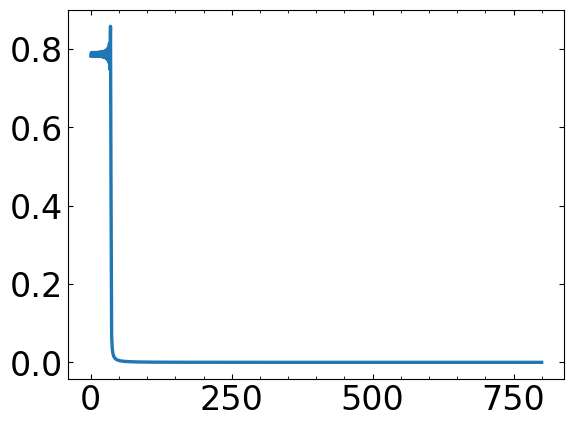

In [219]:
plt.plot(IRF_smooth_spec)
plt.show()

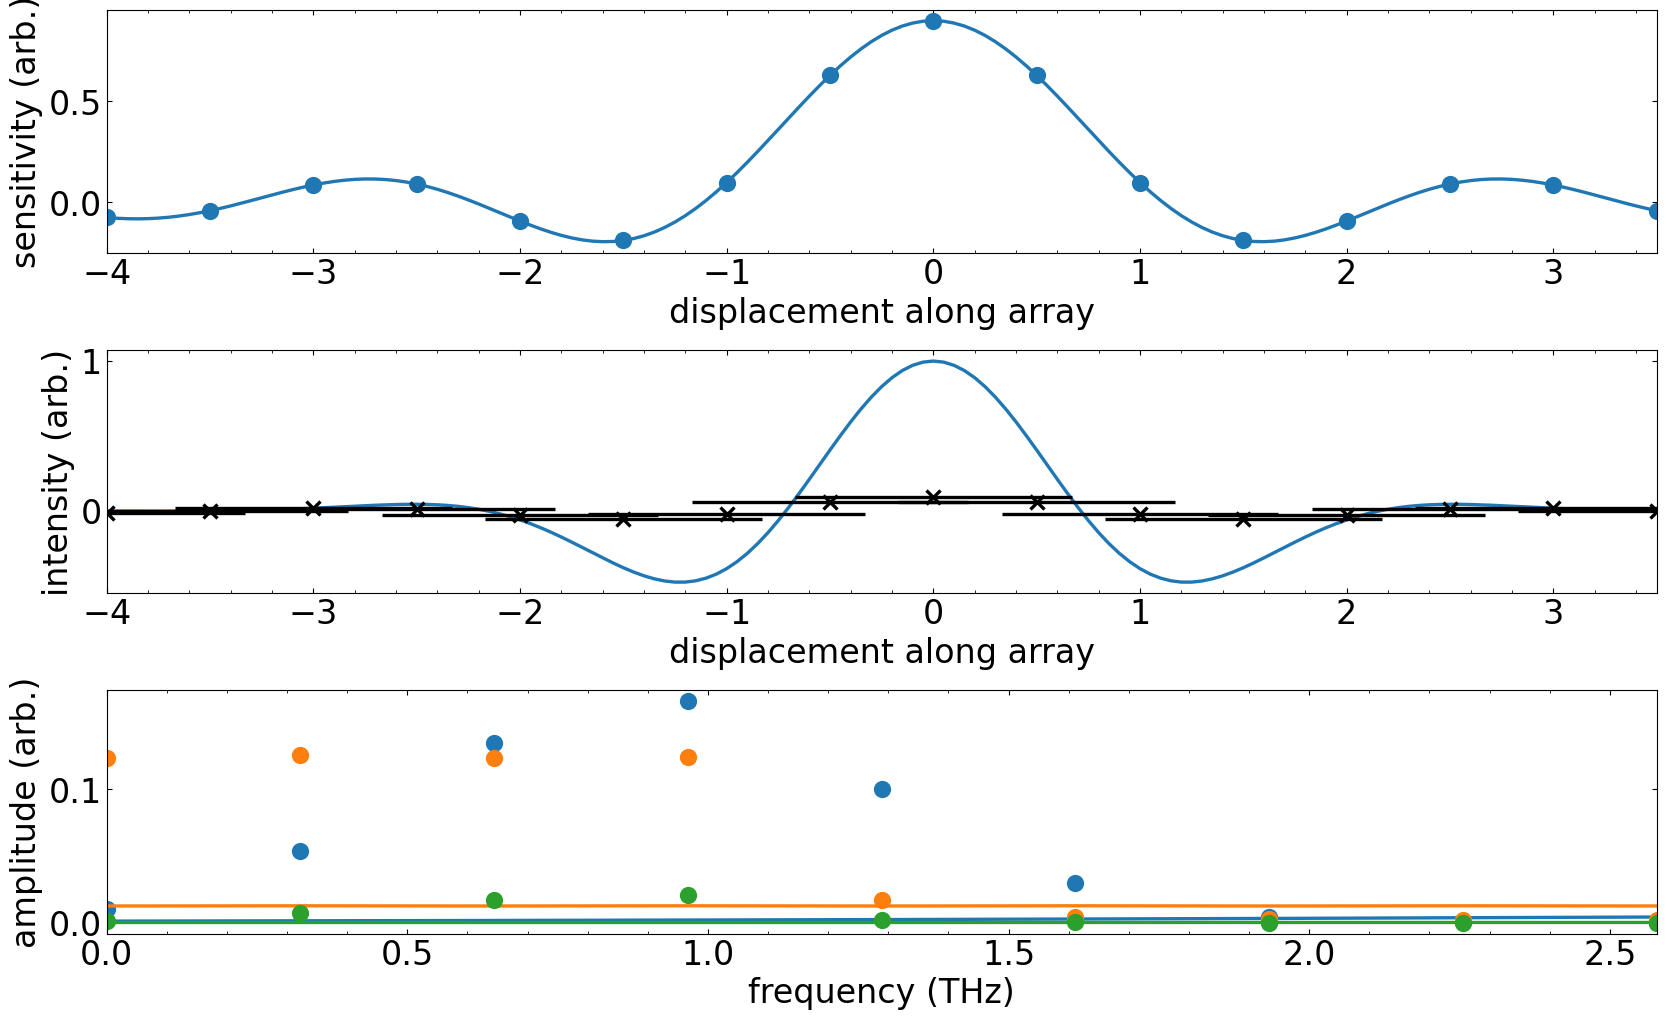

In [208]:

fig, axs = plt.subplots(3, 1, figsize= (20, 12), gridspec_kw= {"hspace": 0.4})

axs[0].plot(np.fft.ifftshift(displacement), np.fft.ifftshift(IRF), linestyle= "none", marker= "o", color= "tab:blue")
axs[0].plot(np.fft.ifftshift(displacement_smooth), np.fft.ifftshift(IRF_smooth), color= "tab:blue")
axs[0].annotate("", xy= (-IRF_FWHM/2, np.pi/base), xytext= (IRF_FWHM/2, np.pi/base), arrowprops= {"arrowstyle": "<->", "shrinkA": 0, "shrinkB": 0})
axs[0].set(xlabel= "displacement along array", ylabel= "sensitivity (arb.)", xlim= (displacement.min(), displacement.max()))

axs[1].plot(np.fft.ifftshift(displacement_smooth), target_smooth, color= "tab:blue")
axs[1].errorbar(np.fft.ifftshift(displacement), convol, xerr= IRF_FWHM/2, color= "k", linestyle= "none", marker= "x")
axs[1].set(xlabel= "displacement along array", ylabel= "intensity (arb.)", xlim= (displacement.min(), displacement.max()))

axs[2].plot(freqs, target_spec, linestyle= "none", marker= "o", color= "tab:blue")
axs[2].plot(freqs_smooth, target_smooth_spec, color= "tab:blue")
axs[2].plot(freqs, IRF_spec, linestyle= "none", marker= "o", color= "tab:orange")
axs[2].plot(freqs_smooth, IRF_smooth_spec, color= "tab:orange")
axs[2].plot(freqs, convol_spec, linestyle= "none", marker= "o", color= "tab:green")
axs[2].plot(freqs_smooth, convol_smooth_spec, color= "tab:green")
axs[2].set(xlabel= "frequency (THz)", ylabel= "amplitude (arb.)", xlim= (freqs.min(), freqs.max()))

plt.show()